<table align="left" border="1" style="font-size:100px">
<th>Nombre</th>
<th>Código</th>
<tr>
</tr>
<tr> 
<td>Jessica marcela ariza florez</td>
<td>2171736</td>
</tr>
</table>



In [137]:
#@title MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/proyecto-IA')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/proyecto-IA


In [2]:
!pip install imbalanced-learn
!pip install eli5

     |████████████████████████████████| 106 kB 8.2 MB/s 


In [3]:
#@title  CARGAR LIBRERÍAS { display-mode: "form" }
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import * 
#from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from matplotlib.pyplot import figure


from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from sklearn.feature_selection import RFE

import seaborn as sns
#from sklearn.preprocessing import StandardScaler
import imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
#from imblearn.combine import SMOTETomek
#from imblearn.ensemble import BalancedBaggingClassifier
#from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

## 1. Observación de los datos

In [138]:
d = pd.read_csv("data/breast-cancer.csv") 
print("tamaño: ",d.shape)
d.head()

tamaño:  (569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Para un mejor tratameinto de los datos se decide modificar los valores de la columna 'diagnosis' cambiando los valores B con 0 y M con 1

In [139]:

d.diagnosis= d.diagnosis.replace('B', 0)
d.diagnosis= d.diagnosis.replace('M', 1)
d.diagnosis.unique()

array([1, 0])

Se verifica que no se encuentre en el dataset datos perdidos o vacios 



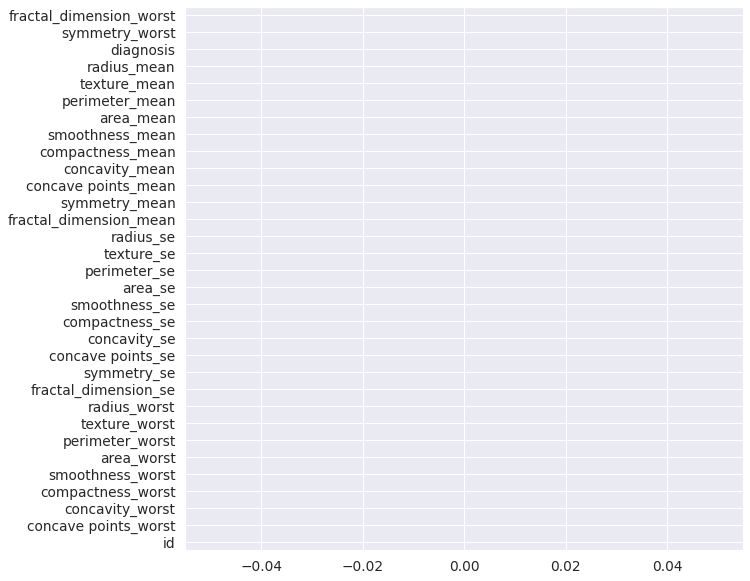

In [140]:

plt.figure(figsize=(10,10))
np.round(d.isnull().sum()/d.shape[0]*100).sort_values().plot(kind='barh')

## 2. Visualización de los datos

Observamos una descripción de la características numéricas del dataset

In [141]:
d[['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']].describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


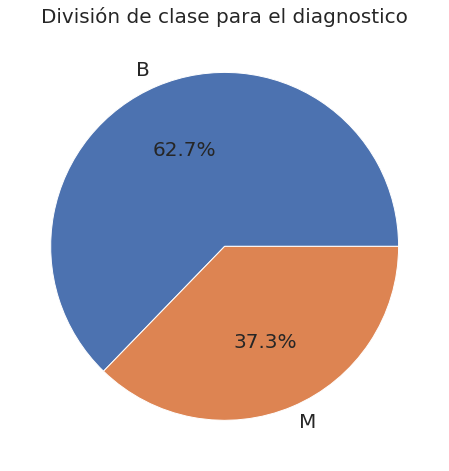

In [142]:
#@title Porcentaje de diagnosticos{ display-mode: "form" }

impute = d.copy()
impute=d.astype('float')

plt.figure(figsize = (8,8))
plt.pie(impute['diagnosis'].value_counts(), labels = ['B', 'M'], autopct = '%1.1f%%', labeldistance=1.1, textprops = {'fontsize': 20})
plt.title('División de clase para el diagnostico', fontsize=20)
plt.show()

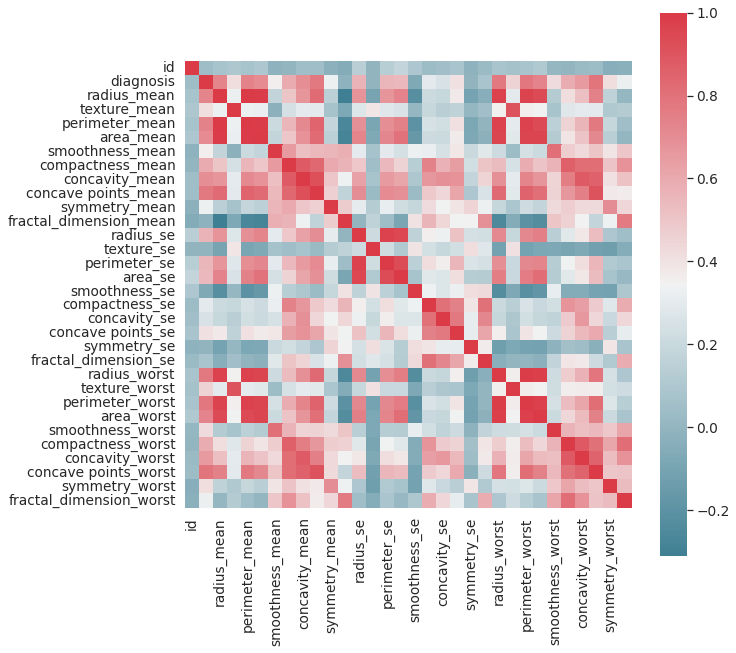

In [143]:
#@title Correlación de los datos { display-mode: "form" }
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 10))
corr = d.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

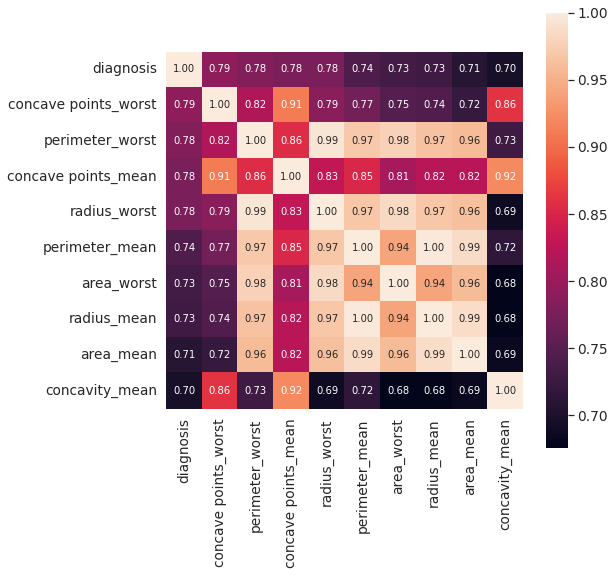

In [145]:
#@title Datos más correlacionados con la variable diagnostico { display-mode: "form" }
k = 10 #numero de caracteristicas
cols = corr.nlargest(k, 'diagnosis')['diagnosis'].index
cm = np.corrcoef(d[cols].values.T)

plt.figure(figsize=(8,8)) 

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels = cols.values, xticklabels = cols.values)
plt.show()

## 3. División de las características y la clase

<p align="justify">Permutamos nuestro dataframe y porteriormente separamos las características de las clases y vemos la distribución de las etiquetas</p>  

In [147]:
#@title Funciones { display-mode: "form" }
def r_model(model,nombre,xtrain,ytrain,xtest,ytest):
  mod = {}
  modelo = model
  modelo.fit(xtrain,ytrain)
  ypred = modelo.predict(xtest)
  mod['Modelo'] = nombre
  mod['Train_Score'] = modelo.score(xtrain,ytrain)
  mod['Test_Score'] = modelo.score(xtest,ytest)
  mod['Test_accuracy'] = accuracy_score(ytest,ypred)
  mod['f1score'] = f1_score(ytest,ypred)
  reca = recall_score(ytest, ypred, average=None)
  mod['recall-0'] = reca[0]
  mod['recall-1'] = reca[1]
  prec = precision_score(ytest, ypred, average=None)
  mod['precision-0'] = prec[0]
  mod['precision-1'] = prec[1]
  mod['roc_auc'] = roc_auc_score(ytest,ypred)
  return mod, ypred

def run_model_MC(est, xtrain, xtest, ytrain, ytest,kfold=10):
  est.fit(xtrain,ytrain)
  ypredict = est.predict(xtest)
  score=cross_val_score(est,xtest,ytest,cv=KFold(kfold,shuffle=True),scoring=make_scorer(accuracy_score))
  return est, ypredict, np.mean(score)

def matriz_confusion(ytest, ypredict):
    target= np.unique(y)
    conf_matrix = confusion_matrix(ytest, ypredict)
    plt.figure(figsize=(7, 4))
    sns.heatmap(conf_matrix, xticklabels=target, yticklabels=target, annot=True, fmt="d");
    plt.title("Matriz de confusión")
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase predicha')
    plt.show()
    print (classification_report(ytest, ypredict))
    return None

def show_train_history(train_history,train,validation):
    plt.figure(figsize=(7, 3))
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

#Objetar la sobremuestra de las clases minoritarias seleccionando muestras al azar con reemplazo.
def SobremuestreoAleatorio(X,y,estrategia):
  os =  RandomOverSampler(sampling_strategy=estrategia)
  X, y = os.fit_sample(X, y)
  return X,y
  
def subsamplingOversampling(X,y,estrategia = 'auto'):
  os_us = SMOTETomek(sampling_strategy=estrategia)
  X, y = os_us.fit_sample(X, y)
  return X,y

def escalarDatos(X):
  X = StandardScaler().fit_transform(X)
  return X

def aplicarPCA(X,nCompo=7):
  pca = PCA(n_components=nCompo)
  X = pca.fit_transform(X)
  return X


In [148]:
np.random.seed(42)
d_shuffle = d.iloc[np.random.permutation(len(d))]
X = d_shuffle.drop('diagnosis', axis=1)
y = d_shuffle["diagnosis"]
print ("Distribución de etiquetas de clase {}".format(Counter(y)))

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=.3, random_state = 1)

Distribución de etiquetas de clase Counter({0: 357, 1: 212})


## 4. Modelo inicial

dimension del dataset:  (569, 32) 

0    357
1    212
Name: diagnosis, dtype: int64


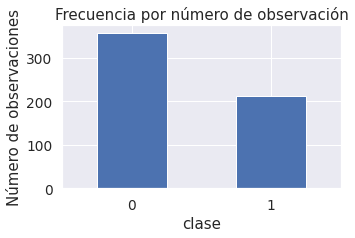

In [149]:
#@title Balance de clases { display-mode: "form" }
target = np.unique(y)
print("dimension del dataset: ",d.shape,"\n")
print(pd.value_counts(d['diagnosis'], sort = True))
plt.subplots(1,1,figsize=(5,3))
count_classes = pd.value_counts(d['diagnosis'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2),target)
plt.title("Frecuencia por número de observación")
plt.xlabel("clase")
plt.ylabel("Número de observaciones");

Predictor: GaussianNB
Score en test:  0.6432748538011696
Score en entrenamiento 0.6432748538011696


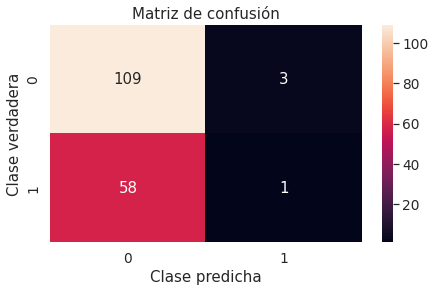

              precision    recall  f1-score   support

           0       0.65      0.97      0.78       112
           1       0.25      0.02      0.03        59

    accuracy                           0.64       171
   macro avg       0.45      0.50      0.41       171
weighted avg       0.51      0.64      0.52       171




Predictor: DecisionTreeClassifier
Score en test:  0.9415204678362573
Score en entrenamiento 0.9415204678362573


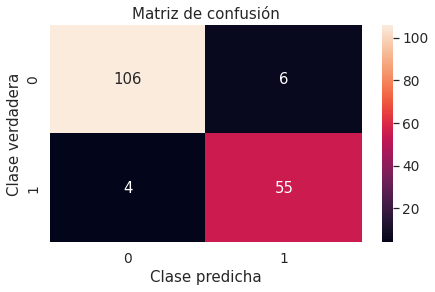

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       112
           1       0.90      0.93      0.92        59

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171




Predictor: RandomForestClassifier
Score en test:  0.9649122807017544
Score en entrenamiento 0.9649122807017544


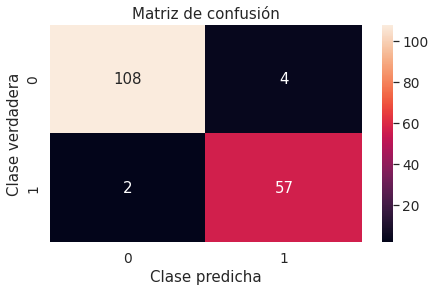

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       112
           1       0.93      0.97      0.95        59

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.97       171




Predictor: SVC
Score en test:  0.631578947368421
Score en entrenamiento 0.631578947368421


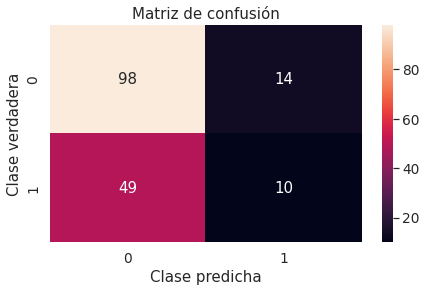

              precision    recall  f1-score   support

           0       0.67      0.88      0.76       112
           1       0.42      0.17      0.24        59

    accuracy                           0.63       171
   macro avg       0.54      0.52      0.50       171
weighted avg       0.58      0.63      0.58       171






In [150]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l=[]
NB = GaussianNB() 
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
RF = RandomForestClassifier(n_estimators=64,max_depth=7,criterion="gini",class_weight="balanced")
SV= SVC(kernel='rbf',degree=3,gamma="scale",cache_size=300,class_weight="balanced")
predictores = ['GaussianNB','DecisionTreeClassifier','RandomForestClassifier','SVC']
PDs = [NB,DT,RF,SV]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],Xtrain,ytrain,Xtest,ytest)
  l.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

In [151]:
base_df = pd.DataFrame(l)
base_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,GaussianNB,0.618090,0.643275,0.643275,0.031746,0.973214,0.016949,0.652695,0.250000,0.495082
1,DecisionTreeClassifier,1.000000,0.941520,0.941520,0.916667,0.946429,0.932203,0.963636,0.901639,0.939316
2,RandomForestClassifier,1.000000,0.964912,0.964912,0.950000,0.964286,0.966102,0.981818,0.934426,0.965194
3,SVC,0.613065,0.631579,0.631579,0.240964,0.875000,0.169492,0.666667,0.416667,0.522246


## 5. Modelo final

### Se hace un Oversampling

Se hace un sobremuestreo en los datos de entrenamiento y se crean muestras artificiales para la clase minoritaria

In [152]:
Xtrain_s, ytrain_s = RandomOverSampler(random_state=33).fit_resample(Xtrain, ytrain.ravel())
print(sorted(Counter(ytrain_s).items()))

[(0, 245), (1, 245)]


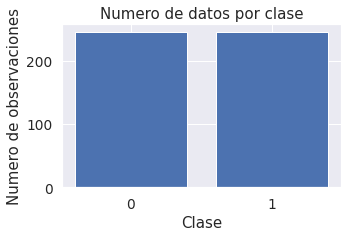

In [153]:
#@title Balance de clases  { display-mode: "form" }
plt.subplots(1,1,figsize=(5,3))
target= ['0', '1']
lista = [np.sum(ytrain_s==0),np.sum(ytrain_s==1)]
plt.bar(target, lista)
plt.title("Numero de datos por clase")
plt.xlabel("Clase")
plt.ylabel("Numero de observaciones");

Predictor: GaussianNB
Score en test:  0.6432748538011696
Score en entrenamiento 0.6432748538011696


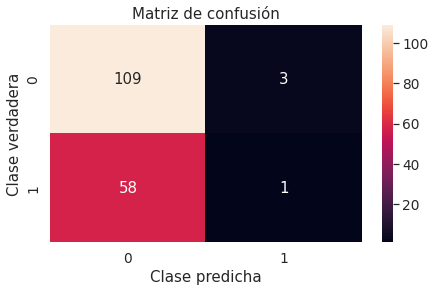

              precision    recall  f1-score   support

           0       0.65      0.97      0.78       112
           1       0.25      0.02      0.03        59

    accuracy                           0.64       171
   macro avg       0.45      0.50      0.41       171
weighted avg       0.51      0.64      0.52       171




Predictor: DecisionTreeClassifier
Score en test:  0.935672514619883
Score en entrenamiento 0.935672514619883


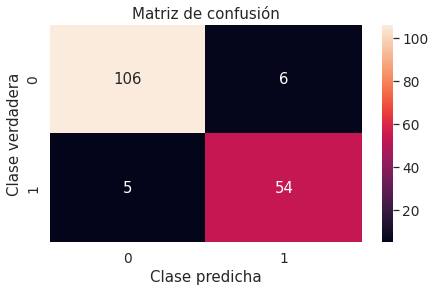

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       112
           1       0.90      0.92      0.91        59

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171




Predictor: RandomForestClassifier
Score en test:  0.9766081871345029
Score en entrenamiento 0.9766081871345029


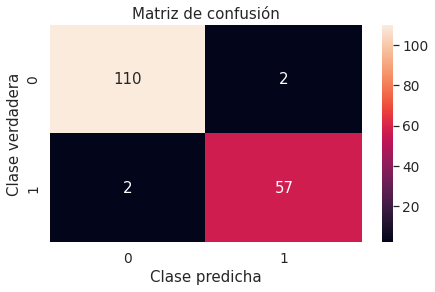

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       112
           1       0.97      0.97      0.97        59

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171




Predictor: SVC
Score en test:  0.631578947368421
Score en entrenamiento 0.631578947368421


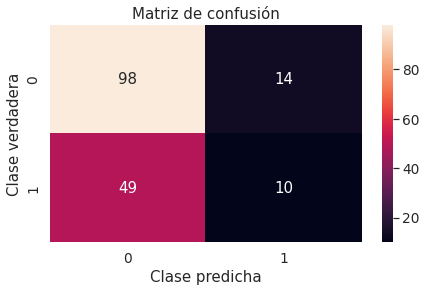

              precision    recall  f1-score   support

           0       0.67      0.88      0.76       112
           1       0.42      0.17      0.24        59

    accuracy                           0.63       171
   macro avg       0.54      0.52      0.50       171
weighted avg       0.58      0.63      0.58       171






In [89]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l_final=[]
NB = GaussianNB() 
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
RF = RandomForestClassifier(n_estimators=64,max_depth=7,criterion="gini",class_weight="balanced")
SV= SVC(kernel='rbf',degree=3,gamma="scale",cache_size=300,class_weight="balanced")
predictores = ['GaussianNB','DecisionTreeClassifier','RandomForestClassifier','SVC']
PDs = [NB,DT,RF,SV]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],Xtrain_s,ytrain_s,Xtest,ytest)
  l_final.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

In [154]:
oversampling_df = pd.DataFrame(l_final)
oversampling_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,GaussianNB,0.506122,0.643275,0.643275,0.031746,0.973214,0.016949,0.652695,0.250000,0.495082
1,DecisionTreeClassifier,1.000000,0.935673,0.935673,0.907563,0.946429,0.915254,0.954955,0.900000,0.930841
2,RandomForestClassifier,1.000000,0.976608,0.976608,0.966102,0.982143,0.966102,0.982143,0.966102,0.974122
3,SVC,0.530612,0.631579,0.631579,0.240964,0.875000,0.169492,0.666667,0.416667,0.522246


### Seleccionamos las mejores características para los diferentes predictores

Hemos utilizado la técnica RFE para la selección de características.
Eliminación de características recursivas (RFE), como sugiere su título, elimina características de manera recursiva, crea un modelo utilizando los atributos restantes y calcula la precisión del modelo.
RFE puede calcular la combinación de atributos que contribuyen a la predicción de la variable (o clase) objetivo.
Las características se eligen en función de la puntuación de recall, es decir, qué conjunto de características dió la puntuación de recall más alta

primero se usa un DecisionTreeClassifier() 

In [196]:
X1 = X

In [199]:
for i in range(1,d.shape[1]):
    model = RFE(DecisionTreeClassifier(),n_features_to_select=i,step=1).fit(X1,y)
    print(X1.columns[model.support_])
    x_train,x_test,y_train,y_test = train_test_split(model.transform(X1),y,test_size=0.3,random_state=0)
    dt = DecisionTreeClassifier()
    dt.fit(x_train,y_train)
    y_pred = dt.predict(x_test)
    dt_recall = roc_auc_score(y_test,y_pred)
    reca = recall_score(y_test, y_pred, average=None)
    print('roc_auc',dt_recall)
    print('recall-0', reca[0])
    print('recall-1', reca[1])
    print('# Features: ',i)
    print('*'*100)

Index(['radius_worst'], dtype='object')
roc_auc 0.8896123113347145
recall-0 0.908256880733945
recall-1 0.8709677419354839
# Features:  1
****************************************************************************************************
Index(['radius_worst', 'concave points_worst'], dtype='object')
roc_auc 0.918393015685114
recall-0 0.9174311926605505
recall-1 0.9193548387096774
# Features:  2
****************************************************************************************************
Index(['radius_worst', 'texture_worst', 'concave points_worst'], dtype='object')
roc_auc 0.9321544835750223
recall-0 0.944954128440367
recall-1 0.9193548387096774
# Features:  3
****************************************************************************************************
Index(['radius_worst', 'texture_worst', 'smoothness_worst',
       'concave points_worst'],
      dtype='object')
roc_auc 0.9160254513169577
recall-0 0.944954128440367
recall-1 0.8870967741935484
# Features:  4
**********

In [198]:
rfe_dt=['texture_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'texture_se', 'area_se', 'smoothness_se', 'concave points_se',
       'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst']
len(rfe_dt)

21

Ahora se usa un RandomForestClassifier()

In [158]:
for i in range(1,d.shape[1]):
    model = RFE(RandomForestClassifier(),n_features_to_select=i,step=1).fit(X1,y)
    print(X1.columns[model.support_])
    x_train,x_test,y_train,y_test = train_test_split(model.transform(X1),y,test_size=0.3,random_state=0)
    dt = RandomForestClassifier()
    dt.fit(x_train,y_train)
    y_pred = dt.predict(x_test)
    dt_recall = roc_auc_score(y_test,y_pred)
    reca = recall_score(y_test, y_pred, average=None)
    print('roc_auc',dt_recall)
    print('recall-0', reca[0])
    print('recall-1', reca[1])
    print('# Features: ',i)
    print('*'*100)

Index(['perimeter_worst'], dtype='object')
roc_auc 0.8828055637762652
recall-0 0.8623853211009175
recall-1 0.9032258064516129
****************************************************************************************************
Index(['area_worst', 'concave points_worst'], dtype='object')
roc_auc 0.9517608759988162
recall-0 0.9357798165137615
recall-1 0.967741935483871
****************************************************************************************************
Index(['perimeter_worst', 'area_worst', 'concave points_worst'], dtype='object')
roc_auc 0.9379994081089079
recall-0 0.908256880733945
recall-1 0.967741935483871
****************************************************************************************************
Index(['radius_worst', 'perimeter_worst', 'area_worst',
       'concave points_worst'],
      dtype='object')
roc_auc 0.9471737200355135
recall-0 0.926605504587156
recall-1 0.967741935483871
**************************************************************************

In [200]:
rfe_rf=['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst',
       'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst']
len(rfe_rf)

15

In [201]:
x_train_s = pd.DataFrame(Xtrain_s, columns = X.columns)
y_train_s = pd.DataFrame(ytrain_s, columns = ['diagnosis'])
x_test = pd.DataFrame(Xtest, columns=X.columns)

rfe_dt_df_train = x_train_s[rfe_dt]
rfe_dt_df_test = x_test[rfe_dt]
rfe_rf_df_train = x_train_s[rfe_rf]
rfe_rf_df_test = x_test[rfe_rf]

B = [(rfe_dt_df_train,rfe_dt_df_test),(rfe_rf_df_train,rfe_rf_df_test)]

Predictor: DecisionTreeClassifier
Score en test:  0.9473684210526315
Score en entrenamiento 0.9473684210526315


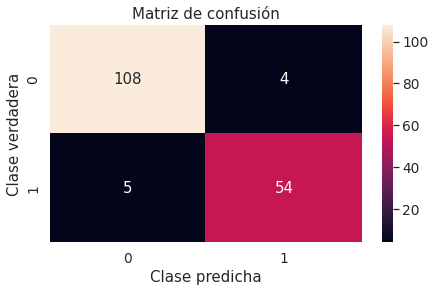

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       112
           1       0.93      0.92      0.92        59

    accuracy                           0.95       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171




Predictor: RandomForestClassifier
Score en test:  0.9707602339181286
Score en entrenamiento 0.9707602339181286


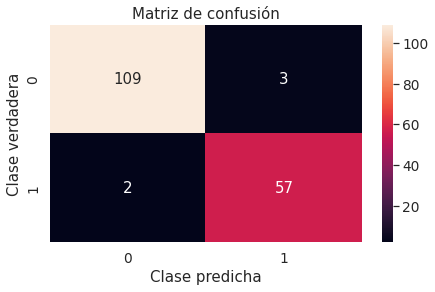

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       112
           1       0.95      0.97      0.96        59

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171






In [202]:
#@title Pruebas con los clasificadores { display-mode: "form" }
l_final_BF=[]
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced")
RF = RandomForestClassifier(n_estimators=64,max_depth=7,criterion="gini",class_weight="balanced")
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],B[i][0],ytrain_s,B[i][1],ytest)
  l_final_BF.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

In [203]:
BF_oversampling_df = pd.DataFrame(l_final_BF)
BF_oversampling_df

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,1.0,0.947368,0.947368,0.923077,0.964286,0.915254,0.955752,0.931034,0.939770
1,RandomForestClassifier,1.0,0.970760,0.970760,0.957983,0.973214,0.966102,0.981982,0.950000,0.969658


##Sólo con 	las 15 mejores caracteristicas usando el RandomForestClassifier()

In [206]:
rfe_rfc = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst',
       'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst']
x_train_s = pd.DataFrame(Xtrain_s, columns = X.columns)
y_train_rfc = pd.DataFrame(ytrain_s, columns = ['diagnosis'])
x_test = pd.DataFrame(Xtest, columns=X.columns)

rfc_train = x_train_s[rfe_rfc]
rfc_test = x_test[rfe_rfc]

C = [(rfc_train,rfc_test)]

Predictor: DecisionTreeClassifier
Score en test:  0.935672514619883
Score en entrenamiento 0.935672514619883


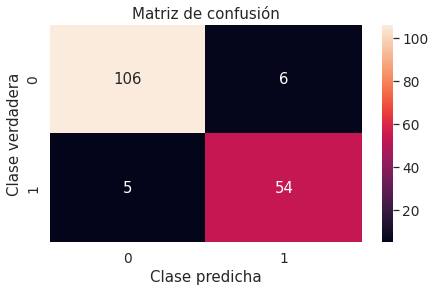

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       112
           1       0.90      0.92      0.91        59

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171




Predictor: RandomForestClassifier
Score en test:  0.9707602339181286
Score en entrenamiento 0.9707602339181286


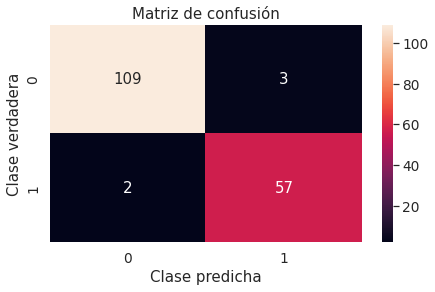

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       112
           1       0.95      0.97      0.96        59

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171






In [207]:
#@title Pruebas con los clasificadores { display-mode: "form" }
rfc = []
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=7,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],rfc_train,y_train_rfc,rfc_test,ytest)
  rfc.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

In [208]:
df_rfc = pd.DataFrame(rfc)
df_rfc

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,1.000000,0.935673,0.935673,0.907563,0.946429,0.915254,0.954955,0.90,0.930841
1,RandomForestClassifier,0.981633,0.970760,0.970760,0.957983,0.973214,0.966102,0.981982,0.95,0.969658


##Sólo con las 10 caracteristicas de la matriz de correlaccion 

In [209]:
rfe_mc = ['concave points_worst','perimeter_worst','concave points_mean','radius_worst','perimeter_mean','area_worst','radius_mean','area_mean','concavity_mean']
x_train_s = pd.DataFrame(Xtrain_s, columns = X.columns)
y_train_s = pd.DataFrame(ytrain_s, columns = ['diagnosis'])
x_test = pd.DataFrame(Xtest, columns=X.columns)

mc_train = x_train_s[rfe_mc]
mc_test = x_test[rfe_mc]

Predictor: DecisionTreeClassifier
Score en test:  0.9181286549707602
Score en entrenamiento 0.9181286549707602


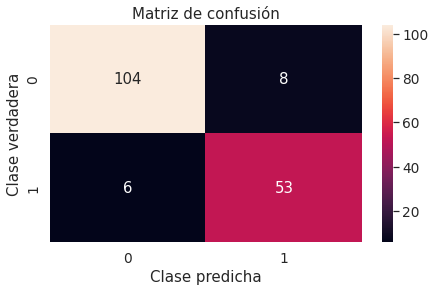

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       112
           1       0.87      0.90      0.88        59

    accuracy                           0.92       171
   macro avg       0.91      0.91      0.91       171
weighted avg       0.92      0.92      0.92       171




Predictor: RandomForestClassifier
Score en test:  0.9298245614035088
Score en entrenamiento 0.9298245614035088


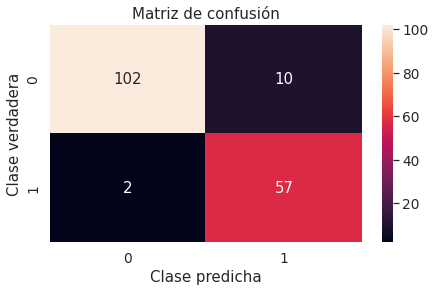

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       112
           1       0.85      0.97      0.90        59

    accuracy                           0.93       171
   macro avg       0.92      0.94      0.92       171
weighted avg       0.94      0.93      0.93       171






In [210]:
#@title Pruebas con los clasificadores { display-mode: "form" }
mc = []
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=7,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)
predictores = ['DecisionTreeClassifier','RandomForestClassifier']
PDs = [DT,RF]
for i,j in enumerate(PDs):
  print("Predictor: {}".format(predictores[i]))
  model,predic = r_model(j,predictores[i],mc_train,y_train_s,mc_test,ytest)
  mc.append(model)
  print("Score en test: ",model['Test_Score'])
  print("Score en entrenamiento",model['Test_accuracy'])
  matriz_confusion(ytest, predic)
  print("\n\n")

In [211]:
df_mc = pd.DataFrame(mc)
df_mc

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,1.000000,0.918129,0.918129,0.883333,0.928571,0.898305,0.945455,0.868852,0.913438
1,RandomForestClassifier,0.969388,0.929825,0.929825,0.904762,0.910714,0.966102,0.980769,0.850746,0.938408


##Análisis

Modelo base

In [212]:
base_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,GaussianNB,0.618090,0.643275,0.643275,0.031746,0.973214,0.016949,0.652695,0.250000,0.495082
1,DecisionTreeClassifier,1.000000,0.941520,0.941520,0.916667,0.946429,0.932203,0.963636,0.901639,0.939316
2,RandomForestClassifier,1.000000,0.964912,0.964912,0.950000,0.964286,0.966102,0.981818,0.934426,0.965194
3,SVC,0.613065,0.631579,0.631579,0.240964,0.875000,0.169492,0.666667,0.416667,0.522246


Modelo con balance de clases

In [213]:
oversampling_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,GaussianNB,0.506122,0.643275,0.643275,0.031746,0.973214,0.016949,0.652695,0.250000,0.495082
1,DecisionTreeClassifier,1.000000,0.935673,0.935673,0.907563,0.946429,0.915254,0.954955,0.900000,0.930841
2,RandomForestClassifier,1.000000,0.976608,0.976608,0.966102,0.982143,0.966102,0.982143,0.966102,0.974122
3,SVC,0.530612,0.631579,0.631579,0.240964,0.875000,0.169492,0.666667,0.416667,0.522246


Modelo con las mejores características y con balance de clases

In [214]:
BF_oversampling_df.head()

,Modelo,Train_Score,Test_Score,Test_accuracy,f1score,recall-0,recall-1,precision-0,precision-1,roc_auc
0,DecisionTreeClassifier,1.0,0.947368,0.947368,0.923077,0.964286,0.915254,0.955752,0.931034,0.939770
1,RandomForestClassifier,1.0,0.970760,0.970760,0.957983,0.973214,0.966102,0.981982,0.950000,0.969658


In [215]:
print("Mejores Características DT: ",rfe_dt)
print("\nMejores Características RT: ",rfe_rf)

Mejores Características DT:  ['texture_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'area_se', 'smoothness_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst']

Mejores Características RT:  ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst']


In [216]:
import eli5
from eli5.sklearn import PermutationImportance
DT = DecisionTreeClassifier(max_depth=7,criterion="gini",class_weight="balanced",splitter='best')
RF = RandomForestClassifier(n_estimators=30,max_depth=7,criterion="entropy",class_weight="balanced",max_features='log2',max_leaf_nodes=7)

print('Características más importantes de DecisionTreeClassifier' )
DT.fit(B[0][0],ytrain_s)
permumtation_impor = PermutationImportance(DT, random_state=2019).fit(B[0][1], ytest)
eli5.show_weights(permumtation_impor, feature_names = B[0][1].columns.tolist())

Características más importantes de DecisionTreeClassifier


Weight,Feature
0.1053 ± 0.0148,concave points_worst
0.1029 ± 0.0441,concave points_mean
0.0725 ± 0.0094,area_se
0.0538 ± 0.0470,perimeter_worst
0.0129 ± 0.0172,texture_worst
0.0047 ± 0.0047,fractal_dimension_se
0 ± 0.0000,compactness_worst
0 ± 0.0000,texture_mean
0 ± 0.0000,area_worst
0 ± 0.0000,radius_worst


In [217]:
print('Características más importantes de RandomForestClassifier' )
RF.fit(B[1][0],ytrain_s)
permumtation_impor = PermutationImportance(RF, random_state=2019).fit(B[1][1], ytest)
eli5.show_weights(permumtation_impor, feature_names = B[1][1].columns.tolist())

Características más importantes de RandomForestClassifier


Weight,Feature
0.0117 ± 0.0196,perimeter_worst
0.0105 ± 0.0172,concave points_worst
0.0094 ± 0.0057,perimeter_mean
0.0070 ± 0.0047,radius_mean
0.0058 ± 0.0074,smoothness_worst
0.0058 ± 0.0000,texture_worst
0.0035 ± 0.0057,concave points_mean
0.0023 ± 0.0241,radius_worst
0.0023 ± 0.0057,area_se
0.0012 ± 0.0047,concavity_mean


<p align="justify">Podemos observar que las características más significantes para nuestros modelos se encuentran principalmente en la prueba de Hinselmann y la de Shiller, sin embargo también hay otras características como la citología que también son relevantes, esto además lo podemos corroborar con la matriz de correlación, en donde estas tres características son la más correlacionadas con la Biopsia, esto coincide en sentido común del conocimiento médico, además pudimos observar que al balancear nuestra clase minoritaria (1) nuestros algoritmos presentan un falso negativo y falso positivo realmente bajo, aunque lo realmente importante para nosotros es que el sistema pueda clasificar de una mejor manera nuestra clase (1) que hace referencia a los falsos negativos, ya que esto representa las mujeres que realmente necesitan la biopcia y el modelo predice que no la requiere.</p>